In [1]:
#Mitiq tools
from mitiq.pec import NoisyOperation, execute_with_pec
from mitiq.pec.representations.optimal import (find_optimal_representation, 
                                               minimize_one_norm)

from mitiq import QPROGRAM
from mitiq.interface import convert_to_mitiq
from mitiq.pec.types import NoisyBasis, OperationRepresentation
# from mitiq.pec.channels import choi_to_super, _circuit_to_choi

#Helper libraries
from typing import cast, List, Optional
import numpy as np
import numpy.typing as npt
import scipy as sp
from scipy.optimize import minimize, LinearConstraint
from scipy.linalg import sqrtm

#make numpy matrices easier to read
np.set_printoptions(precision=3, linewidth=125, suppress=True)

# Qiskit
import qiskit
from qiskit.quantum_info import PTM, SuperOp, Kraus, Pauli, Operator
from qiskit import QuantumCircuit, QuantumRegister, execute
from qiskit.test.mock import *
from qiskit.providers.fake_provider import *
from qiskit.providers.aer import AerSimulator, QasmSimulator, Aer
from qiskit.providers.aer.noise import (phase_amplitude_damping_error, 
                                        amplitude_damping_error, pauli_error,
                                        depolarizing_error)
from qiskit.providers.aer.noise.noise_model import NoiseModel
from qiskit.quantum_info.operators.channel.transformations import *
from qiskit.quantum_info.operators.channel.quantum_channel import QuantumChannel
from qiskit.quantum_info.operators.channel.transformations import (_choi_to_kraus, 
                                                                   _kraus_to_superop)
from qiskit.quantum_info.operators.channel.transformations import (_kraus_to_choi,
                                                                   _choi_to_superop)

# Cirq library used as a frontend for interfacing Mitiq
# import cirq

from qutip import *
from qutip.qip.operations import expand_operator, hadamard_transform, cnot, rz
from qutip.steadystate import steadystate

# Has to come after QuTiP or the QuTiP functions of the same name get priority
from mitiq.pec.channels import (matrix_to_vector, kraus_to_super, 
                                choi_to_super, _circuit_to_choi,
                                super_to_choi)

import json

from timeit import default_timer as timer

import matplotlib.ticker as tck
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from PauliPER.ns_utils_ import (_Trotter, find_optimal_representation_super,
                       z_Trotter_new, mk_circ)

# Running circuits on backends with noise models:

### Start by making the noise models:

In [2]:
# These are the variables for the noise models:
amp_damp_var = 0.006 # 0.125 (0.125 is for reaching the steady state)
phase_damp_var = 0.02
# These three variables go into my functions
TFIM = True # Sets transverse field Ising model
xbasis = True # Puts the initial state into the all + state
xmeas = True # Adds Hadamards to the end of the circuit
# The time step (recall that Qiskit uses e^{-i * op * t / 2})
dt = 0.2 # If TFIM = True, then dt has to be short (~0.4 or less)

Note that the function phase_amp_damping_error(a,b) makes an error channel with Kraus operators that are (at least equivalent to):

\begin{align}
& K^{APD}_0 = \begin{pmatrix}1 & 0 \\ 0 & \sqrt{1-a-b} \end{pmatrix}\, , && K^{APD}_1 = \begin{pmatrix} 0 & \sqrt{a} \\ 0 & 0 \end{pmatrix}\, , && K^{APD}_2 = \begin{pmatrix} 0 & 0 \\ 0 & \sqrt{b} \end{pmatrix}\, . &
\end{align}

For AD noise, the function amplitude_damping_error(a) makes an error channel with the same Kraus operators only with $b = 0$.

In [3]:
''' This is the APD error model. '''

# Single qubit error
error_apd = phase_amplitude_damping_error(amp_damp_var, phase_damp_var)
# Two-qubit error
error_2q_apd = error_apd.tensor(error_apd)
# Makes the empty NoiseModel object
noise_model_apd = NoiseModel()
# Add noise to the noise model
noise_model_apd.add_all_qubit_quantum_error(error_apd, ['u']) # 1 qubit error
noise_model_apd.add_all_qubit_quantum_error(error_2q_apd, ['cx']) # 2 qubit error
# Extra single-qubit gates one might want to add noise to in addition to 'u': 
# 'u3', 'u1', 'u2', 'u', 'h', 's', 'sdg', 'sx'

In [4]:
''' This is the AD error model. '''

error_ad = amplitude_damping_error(amp_damp_var)
error_2q_ad = error_ad.tensor(error_ad)
noise_model_ad = NoiseModel()
noise_model_ad.add_all_qubit_quantum_error(error_ad, ['u'])
noise_model_ad.add_all_qubit_quantum_error(error_2q_ad, ['cx'])

In [5]:
''' Make the backends with error. '''
backend_apd = AerSimulator(noise_model = noise_model_apd)
backend_ad = AerSimulator(noise_model = noise_model_ad)

### Create and run circuits with the backends:

In [6]:
''' Set the number of sites, shots, and Trotter steps for this section. '''

N = 2 # For two qubits
shots = 20000 # Number of shots
steps = np.linspace(0, 20, 21) # This sets how many Trotter steps to take

In [7]:
''' Now make/run Trotter circuits for the APD model using _Trotter(). '''

trott_dicts_apd = []
# Create and run circuits:
for step in steps:
    qc_apd = _Trotter(dt, N, backend_apd, int(step), x=xbasis,
                      xx=xmeas, pbc=False, TFIM=TFIM, dtH=dt)
    qc_apd.measure_all()

    res_apd = backend_apd.run(qc_apd, shots=shots)
    trott_dicts_apd.append(res_apd.result().get_counts())

# Break up the combined results into results for individual qubits:
prob_results_apd = []
for res_dict in trott_dicts_apd:
    temp_dict = {}
    for i in range(N):
        temp_dict[f'x{i}u'] = 0
        for key in res_dict:
            if key[i] == '0':
                temp_dict[f'x{i}u'] += res_dict[key]/shots
    prob_results_apd.append(temp_dict)

# Work out the x-magnetization:
mx_dict_apd = {}
for step, prob in zip(steps, prob_results_apd):
    mx_dict_apd[f'{step * dt / 2}'] = 0
    for key in prob:
        mx_dict_apd[f'{step * dt / 2}'] += (2*prob[key] - 1)
        
thymes_apd = [float(x) for x in mx_dict_apd.keys()]
mx_shots_apd = [mx_dict_apd[key] for key in mx_dict_apd]
print(mx_shots_apd)

[2.0, 1.8530999999999997, 1.6334, 1.4237, 1.2026999999999999, 1.0377999999999998, 0.9127000000000001, 0.8441000000000003, 0.8328999999999998, 0.8595999999999999, 0.9091000000000002, 0.9521000000000002, 0.9847000000000001, 0.9814, 0.9470000000000001, 0.8912999999999998, 0.7965, 0.7081000000000002, 0.6207, 0.5454000000000001, 0.48419999999999996]


In [8]:
''' Repeat the process for the AD noise model. '''

trott_dicts_ad = []
for step in steps:
    qc_ad = _Trotter(dt, N, backend_ad, int(step), x=xbasis, 
                     xx=xmeas, pbc=False, TFIM=TFIM, dtH=dt)
    qc_ad.measure_all()

    res_ad = backend_ad.run(qc_ad, shots=shots)
    trott_dicts_ad.append(res_ad.result().get_counts())
    
prob_results_ad = []
for res_dict in trott_dicts_ad:
    temp_dict = {}
    for i in range(N):
        temp_dict[f'x{i}u'] = 0
        for key in res_dict:
            if key[i] == '0':
                temp_dict[f'x{i}u'] += res_dict[key]/shots
    prob_results_ad.append(temp_dict)
    
mx_dict_ad = {}
for step, prob in zip(steps, prob_results_ad):
    mx_dict_ad[f'{step * dt / 2}'] = 0
    for key in prob:
        mx_dict_ad[f'{step * dt / 2}'] += (2*prob[key] - 1)
        
thymes_ad = [float(x) for x in mx_dict_ad.keys()]
mx_shots_ad = [mx_dict_ad[key] for key in mx_dict_ad]
print(mx_shots_ad)

[2.0, 1.9330999999999998, 1.8049, 1.633, 1.4635, 1.2933, 1.1847, 1.1501000000000001, 1.1480000000000001, 1.2414, 1.3633, 1.4616000000000002, 1.579, 1.6418000000000001, 1.6622999999999999, 1.6152999999999997, 1.5452000000000001, 1.3992, 1.2716999999999998, 1.1801000000000001, 1.0949]


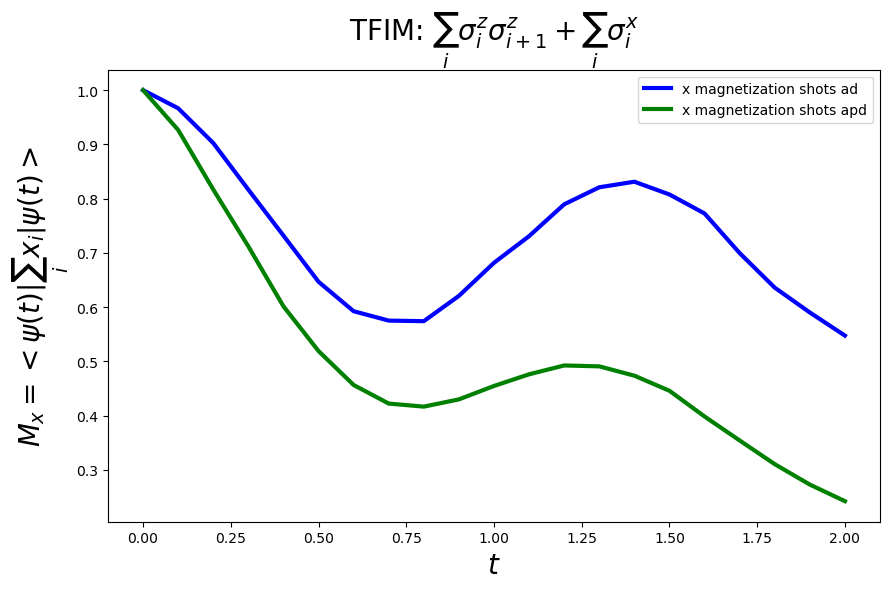

In [9]:
''' Plot the outcome: '''

# bw = 'white'
bw = 'black'

fig, axes = plt.subplots(1,1, figsize=(9,6))

axes.plot(thymes_ad[0:21], [x/N for x in mx_shots_ad[0:21]],'b',linewidth=3, 
          label='x magnetization shots ad')
axes.plot(thymes_apd[0:21], [x/N for x in mx_shots_apd[0:21]],'g',linewidth=3, 
          label='x magnetization shots apd')

axes.legend()

axes.set_title(r'TFIM: $\sum_i \sigma^z_i \sigma^z_{i+1} + \sum_i \sigma^x_i$', 
               fontsize=20, color=bw)

axes.set_xlabel(r'$t$', fontsize=20, color=bw)
axes.set_ylabel(r'$M_x = < \psi(t)| \sum_i x_i | \psi(t) >$', fontsize=20, color=bw)
axes.tick_params(colors=bw, which='both')  # 'both' refers to minor and major axes

fig.tight_layout()
plt.show()

# Now look at obtaining AD noise with APD circuits:

In order to do this, we want to express AD circuit elements as a linear combination of APD circuits:

\begin{equation}
\mathcal{G}^{AD}_{i} = \sum_{\alpha} \eta_{i, \alpha} \mathcal{O}^{APD}_{i, \alpha}\, , 
\end{equation}

with $\sum_\alpha \eta_{i,\alpha} = 1$ and $\sum_\alpha |\eta_{i,\alpha}| = \gamma_i \geq 1$ for any particular gate $\mathcal{G}_i$. In what follows, we break each of the necessary gates up into its constituent parts -- in particular, the rzz gate -- and perform a minimization of $\gamma_i$ for each gate $i$.

In [10]:
'''
Here, we make the requisite circuit elements. We will need the individual gates
and the gates necessary for the expansions.
'''

# Choose the angle for everything that follows. Remember Qiskit uses e^{-i t/2 Op}
thet = 0.2

## 1 qubit gates
qcrz = mk_circ(one='rz', theta=thet)
qcrx = mk_circ(one='rx', theta=thet)
qcz = mk_circ(one='z')
qcx = mk_circ(one='x')
qcsx = mk_circ(one='s')
qch = mk_circ(one='h')

## 2 qubit stuff
# 1 qubit gates on 2 qubits using the identity gate
qcrzi = mk_circ(one='rz', two='i', theta=thet)
qcirz = mk_circ(one='i', two='rz', theta=thet)
qcrxi = mk_circ(one='rx', two='i', theta=thet)
qcirx = mk_circ(one='i', two='rx', theta=thet)
qcxi = mk_circ(one='x', two='i')
qcix = mk_circ(one='i', two='x')
qczi = mk_circ(one='z', two='i')
qciz = mk_circ(one='i', two='z')
qcsxi = mk_circ(one='s', two='i')
qcisx = mk_circ(one='i', two='s')
qchi = mk_circ(one='h', two='i')
qcih = mk_circ(one='i', two='h')

# the 2 qubit gates to simulate (ultimately only want CNOT)
qccx = mk_circ(cx='cx')

print(qcx.draw())

   ┌───┐
q: ┤ X ├
   └───┘


In [11]:
'''
Turn each of the circuits (QuantumCircuits) into an ideal super operator. Uses Qiskit
and QuTiP.
'''

rzSupOp = Qobj(SuperOp(qcrz).data).tidyup(atol=1e-10).full()  
rxSupOp = Qobj(SuperOp(qcrx).data).tidyup(atol=1e-10).full()  
zSupOp = Qobj(SuperOp(qcz).data).tidyup(atol=1e-10).full()  
xSupOp = Qobj(SuperOp(qcx).data).tidyup(atol=1e-10).full()  
sxSupOp = Qobj(SuperOp(qcsx).data).tidyup(atol=1e-10).full()  
hSupOp = Qobj(SuperOp(qch).data).tidyup(atol=1e-10).full()  

# These all contain an identity gate on one of the qubits:
rziSupOp = Qobj(SuperOp(qcrzi).data).tidyup(atol=1e-10).full()  
rxiSupOp = Qobj(SuperOp(qcrxi).data).tidyup(atol=1e-10).full()  
irzSupOp = Qobj(SuperOp(qcirz).data).tidyup(atol=1e-10).full()  
irxSupOp = Qobj(SuperOp(qcirx).data).tidyup(atol=1e-10).full()  

xiSupOp = Qobj(SuperOp(qcxi).data).tidyup(atol=1e-10).full()  
ixSupOp = Qobj(SuperOp(qcix).data).tidyup(atol=1e-10).full()  
ziSupOp = Qobj(SuperOp(qczi).data).tidyup(atol=1e-10).full()  
izSupOp = Qobj(SuperOp(qciz).data).tidyup(atol=1e-10).full()  

sxiSupOp = Qobj(SuperOp(qcsxi).data).tidyup(atol=1e-10).full()  
isxSupOp = Qobj(SuperOp(qcisx).data).tidyup(atol=1e-10).full()  

hiSupOp = Qobj(SuperOp(qchi).data).tidyup(atol=1e-10).full()  
ihSupOp = Qobj(SuperOp(qcih).data).tidyup(atol=1e-10).full()  

cxSupOp = Qobj(SuperOp(qccx).data).tidyup(atol=1e-10).full()  

##### We pull the Kraus operators directly out of the NoiseModel object.

In [12]:
# For posterity, this is how you get the Kraus operators out of a backend (IF
# the backend was instantiated using Kraus operators to begin with):
backend_ad.options.noise_model.to_dict();
backend_apd.options.noise_model.to_dict();
k_ops_ad = backend_ad.options.noise_model.to_dict()['errors'][0]['instructions'][0][0]['params']
k_ops_apd = backend_apd.options.noise_model.to_dict()['errors'][0]['instructions'][0][0]['params']

In [13]:
''' We extend the Kraus operators to operate on two qubits using the identity (qeye). '''

supOp0_ad = []
for op in k_ops_ad:
    supOp0_ad.append(tensor(Qobj(op), qeye(2)).full())

supOp1_ad = []
for op in k_ops_ad:
    supOp1_ad.append(tensor(qeye(2), Qobj(op)).full())

supOp0_apd = []
for op in k_ops_apd:
    supOp0_apd.append(tensor(Qobj(op), qeye(2)).full())

supOp1_apd = []
for op in k_ops_apd:
    supOp1_apd.append(tensor(qeye(2), Qobj(op)).full())
    
# Use this to check that they remain Kraus operators:
tot = 0
for op in supOp0_ad:
    tot += op.conj().T @ op
tot

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

This mitiq function, kraus_to_super, creates a super operator out of Kraus operators. It uses the formulation:
\begin{equation}
L = \sum_i K_i \otimes K_i^*
\end{equation}
which is based on:
\begin{equation}
A\big|i\big>\big<j\big|B \leftrightarrow A\otimes B^T \big|i\big>\big|j\big>\, .
\end{equation}

In [14]:
''' Turn the Kraus operators into super operators. '''

## 1 qubit version
l_AD = kraus_to_super(k_ops_ad)
l_APD = kraus_to_super(k_ops_apd)

## 2 qubit versions
# the 0 represents the 0th qubit, 1 the 1st qubit.
l_AD0 = kraus_to_super(supOp0_ad)
l_AD1 = kraus_to_super(supOp1_ad)

l_APD0 = kraus_to_super(supOp0_apd)
l_APD1 = kraus_to_super(supOp1_apd)

In [15]:
''' 
Apply the noise super operators to the ideal gate super operators 
with amp. damp. noise applied: 
'''
noisy_rz_ad = l_AD @ rzSupOp
noisy_rx_ad = l_AD @ rxSupOp
noisy_z_ad = l_AD @ zSupOp
noisy_x_ad = l_AD @ xSupOp
noisy_h_ad = l_AD @ hSupOp
noisy_sx_ad = l_AD @ sxSupOp

noisy_rzi_ad = l_AD0 @ rziSupOp
noisy_irz_ad = l_AD1 @ irzSupOp

noisy_rxi_ad = l_AD0 @ rxiSupOp
noisy_irx_ad = l_AD1 @ irxSupOp

noisy_xi_ad = l_AD0 @ xiSupOp
noisy_ix_ad = l_AD1 @ ixSupOp

noisy_zi_ad = l_AD0 @ ziSupOp
noisy_iz_ad = l_AD1 @ izSupOp

noisy_sxi_ad = l_AD0 @ sxiSupOp
noisy_isx_ad = l_AD1 @ isxSupOp

noisy_hi_ad = l_AD0 @ hiSupOp
noisy_ih_ad = l_AD1 @ ihSupOp

noisy_cx_ad = l_AD0 @ l_AD1 @ cxSupOp

In [16]:
''' 
Apply the noise super operators to the ideal gate super operators 
with amp. damp. + phase damp. noise applied: 
'''

noisy_rz_apd = l_APD @ rzSupOp
noisy_rx_apd = l_APD @ rxSupOp
noisy_z_apd = l_APD @ zSupOp
noisy_x_apd = l_APD @ xSupOp
noisy_h_apd = l_APD @ hSupOp
noisy_sx_apd = l_APD @ sxSupOp

noisy_rzi_apd = l_APD0 @ rziSupOp
noisy_irz_apd = l_APD1 @ irzSupOp

noisy_rxi_apd = l_APD0 @ rxiSupOp
noisy_irx_apd = l_APD1 @ irxSupOp

noisy_xi_apd = l_APD0 @ xiSupOp
noisy_ix_apd = l_APD1 @ ixSupOp

noisy_zi_apd = l_APD0 @ ziSupOp
noisy_iz_apd = l_APD1 @ izSupOp

noisy_sxi_apd = l_APD0 @ sxiSupOp
noisy_isx_apd = l_APD1 @ isxSupOp

noisy_hi_apd = l_APD0 @ hiSupOp
noisy_ih_apd = l_APD1 @ ihSupOp

noisy_cx_apd = l_APD0 @ l_APD1 @ cxSupOp

##### Now we make the bases. Need a basis for CNOT, rz, and rx.

In [17]:
''' All the noisy basis objects we may want to use in our expansions. '''

# Create noisy operations as Mitiq NoisyOperation objects for 1 qubit:

mitiq_noisy_rz = NoisyOperation(qcrz, noisy_rz_apd)
mitiq_noisy_rx = NoisyOperation(qcrx, noisy_rx_apd)
mitiq_noisy_z = NoisyOperation(qcz, noisy_z_apd)
mitiq_noisy_x = NoisyOperation(qcx, noisy_x_apd)
mitiq_noisy_sx = NoisyOperation(qcsx, noisy_sx_apd)
mitiq_noisy_h = NoisyOperation(qch, noisy_h_apd)

# Create noisy operations as Mitiq NoisyOperation objects for 2 qubits:
mitiq_noisy_rzi = NoisyOperation(qcrzi, noisy_rzi_apd) 
mitiq_noisy_irz = NoisyOperation(qcirz, noisy_irz_apd) 

mitiq_noisy_rxi = NoisyOperation(qcrxi, noisy_rxi_apd) 
mitiq_noisy_irx = NoisyOperation(qcirx, noisy_irx_apd) 

mitiq_noisy_xi = NoisyOperation(qcxi, noisy_xi_apd) 
mitiq_noisy_ix = NoisyOperation(qcix, noisy_ix_apd) 

mitiq_noisy_zi = NoisyOperation(qczi, noisy_zi_apd) 
mitiq_noisy_iz = NoisyOperation(qciz, noisy_iz_apd) 

mitiq_noisy_sxi = NoisyOperation(qcsxi, noisy_sxi_apd) 
mitiq_noisy_isx = NoisyOperation(qcisx, noisy_isx_apd) 

mitiq_noisy_hi = NoisyOperation(qchi, noisy_hi_apd) 
mitiq_noisy_ih = NoisyOperation(qcih, noisy_ih_apd) 

mitiq_noisy_cx = NoisyOperation(qccx, noisy_cx_apd)
# We use Z on either qubit, X on either qubit, X^{1/2} on either qubit, and CNOT:
cx_basis = [mitiq_noisy_zi, mitiq_noisy_iz, mitiq_noisy_xi, 
                                 mitiq_noisy_ix, mitiq_noisy_sxi, mitiq_noisy_isx, 
                                 mitiq_noisy_cx]
# Here we expand the basis to include sequences of two objects.
noisy_basis_cx = cx_basis + [NoisyOperation((a.native_circuit).compose(b.native_circuit),
                                  a.channel_matrix @ b.channel_matrix)
                                  for a in cx_basis for b in cx_basis]
# For the RZ gate: use Z, X, X^{1/2}, and RZ as the basis.
rz_basis = [mitiq_noisy_rz, mitiq_noisy_x, mitiq_noisy_sx, mitiq_noisy_z]
# Expand the basis to include sequences of two objects.
noisy_basis_rz = rz_basis + [NoisyOperation((a.native_circuit).compose(b.native_circuit),
                                  a.channel_matrix @ b.channel_matrix)
                                  for a in rz_basis for b in rz_basis]
# For the RX gate: use Z, X, X^{1/2}, and RX as the basis.
rx_basis = [mitiq_noisy_rx, mitiq_noisy_x, mitiq_noisy_sx, mitiq_noisy_z]
# Expand the basis to include sequences of two objects.
noisy_basis_rx = rx_basis + [NoisyOperation((a.native_circuit).compose(b.native_circuit),
                                  a.channel_matrix @ b.channel_matrix)
                                  for a in rx_basis for b in rx_basis]

print("Sequeces of noisy operations to be used as a basis for the rx gate:")
for elem in noisy_basis_rx:
    print(elem.circuit)

Sequeces of noisy operations to be used as a basis for the rx gate:
q_0: ───Rx(0.064π)───
q_0: ───X───
q_0: ───X^0.5───
q_0: ───Z───
q_0: ───Rx(0.064π)───Rx(0.064π)───
q_0: ───Rx(0.064π)───X───
q_0: ───Rx(0.064π)───X^0.5───
q_0: ───Rx(0.064π)───Z───
q_0: ───X───Rx(0.064π)───
q_0: ───X───X───
q_0: ───X───X^0.5───
q_0: ───X───Z───
q_0: ───X^0.5───Rx(0.064π)───
q_0: ───X^0.5───X───
q_0: ───X^0.5───X^0.5───
q_0: ───X^0.5───Z───
q_0: ───Z───Rx(0.064π)───
q_0: ───Z───X───
q_0: ───Z───X^0.5───
q_0: ───Z───Z───


In [18]:
''' Use the modified mitiq function to find the optimal representations. '''

# Have to mess with tol for each manually:
op_cx = find_optimal_representation_super(qccx, noisy_cx_ad, noisy_basis_cx, tol=.00005)
op_rz = find_optimal_representation_super(qcrz, noisy_rz_ad, noisy_basis_rz, tol=.00001)
op_rx = find_optimal_representation_super(qcrx, noisy_rx_ad, noisy_basis_rx, tol=.00001)

print(f'CNOT overhead: {op_cx.norm}, rz overhead: {op_rz.norm}, rx overhead: {op_rx.norm}.')

CNOT overhead: 1.0206216673888908, rz overhead: 1.0147512408313601, rx overhead: 1.012380288343055.


In [19]:
''' Check that these representations reconstruct the desired super operator, e.g., rz: '''

matrices = [m.channel_matrix for m in op_rz.noisy_operations]
mat = sum(m*coeff for (m,coeff) in zip(matrices, op_rz.coeffs))
print("Approximated superoperator")
print(mat)
print('------------------------------')
print("Desired superoperator")
print(noisy_rz_ad)
print('------------------------------')
print('The difference between them')
print(mat-noisy_rz_ad)

Approximated superoperator
[[ 1.   +0.j    -0.   +0.j    -0.   -0.j     0.006+0.j   ]
 [ 0.   +0.j     0.977+0.198j  0.   -0.j    -0.   -0.j   ]
 [ 0.   -0.j     0.   +0.j     0.977-0.198j -0.   +0.j   ]
 [-0.   +0.j     0.   -0.j     0.   +0.j     0.994+0.j   ]]
------------------------------
Desired superoperator
[[1.   +0.j    0.   +0.j    0.   +0.j    0.006+0.j   ]
 [0.   +0.j    0.977+0.198j 0.   +0.j    0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.977-0.198j 0.   +0.j   ]
 [0.   +0.j    0.   +0.j    0.   +0.j    0.994+0.j   ]]
------------------------------
The difference between them
[[ 0.+0.j -0.+0.j -0.-0.j  0.+0.j]
 [ 0.+0.j -0.-0.j  0.-0.j -0.-0.j]
 [ 0.-0.j  0.+0.j -0.+0.j -0.+0.j]
 [-0.+0.j  0.-0.j  0.+0.j -0.+0.j]]


In [20]:
'''
This script makes the Trotter circuits, finds the necessary expectation values, and
stores everything in various dictionaries. I haven't written it into a module yet.
'''

N = 2 # Number of sites
shots = 20000
trot = 10 # max Trotter steps
err = 0.05 # Approximate desired error
rep_tol = 10000. # The maximum allowable number of circuit repetitions
rep_min = 500. # The minimum allowable number of circuit repetitions
ev_interim = {} # Storing all interim expectation values for each step
ev_reps = {} # Store the number of reps at each step
ev_output = {} # Store the final output expectation value at each step
op_h = None
for n in range(trot+1):
    ''' n is the number of Trotter steps in the simulation. '''
    print(f'Calculating Trotter step n = {n}.')
    # Solves for the number of reps required to simulate to precision err:
    rep = ((op_cx.norm**2*op_rz.norm*op_rx.norm**2)**n/err)**2
    if rep > rep_tol:
        reps = int(rep_tol)
    elif rep < rep_min:
        reps = int(rep_min)
    else:
        reps = int(rep)
    ev_reps[f'{n}'] = reps
    dict_results = []
    gamma_results = []
    for i in range(reps):
        START = timer()
        # qc = QuantumCircuit(N)
        trot_circ = z_Trotter_new(op_cx, op_rz, N, backend_apd, n, 
                                  x=xbasis, xx=xmeas, pbc=False, TFIM=TFIM, rx=op_rx)
        # qc = qc.compose(trot_circ[0])
        trot_circ[0].measure_all()
        # Here, use the amp. + phase damp. backend:
        res = backend_apd.run(trot_circ[0], shots=shots)
        dict_results.append(res.result().get_counts())
        gamma_results.append(trot_circ[1] * trot_circ[2])
        # Printing to keep track of the timing and where the script is in the calculation.
        if i % 100 == 0:
            print(f'    It is rep {i} of {reps} total reps. A rep takes {timer() - START} s.')

    prob_results = []
    for res_dict in dict_results:
        temp_dict = {}
        for i in range(int(N)):
            temp_dict[f'x{i}u'] = 0
            for key in res_dict:
                if key[i] == '0':
                    temp_dict[f'x{i}u'] += res_dict[key]/shots
        prob_results.append(temp_dict)

    exp_vals = []
    for ent in prob_results:
        val = 0
        for key in ent:
            val += 2 * ent[key] - 1
        exp_vals.append(val)

    tot_out = []
    for a, b in zip(exp_vals, gamma_results):
        tot_out.append(a*b)
    ev_interim[f'{n}'] = tot_out
    ev_output[f'{n}'] = sum(tot_out)/len(tot_out)
    
print(ev_output)

Calculating Trotter step n = 0.
    It is rep 0 of 500 total reps. A rep takes 0.03076617600163445 s.
    It is rep 100 of 500 total reps. A rep takes 0.027290339989122003 s.


KeyboardInterrupt: 

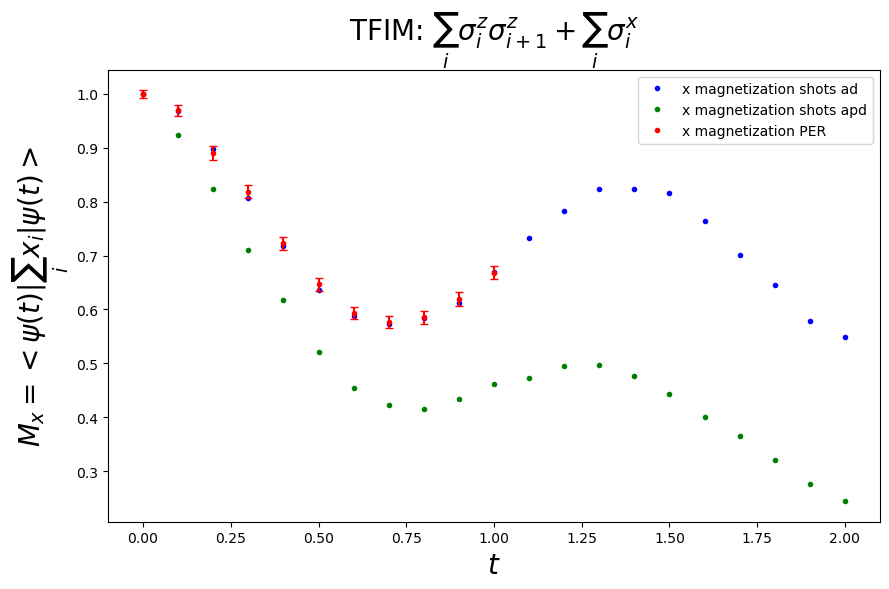

In [39]:
''' Plot all the outcomes together: '''

# bw = 'white'
bw = 'black'

fig, axes = plt.subplots(1,1, figsize=(9,6))

axes.plot(thymes_ad[0:21], [x/N for x in mx_shots_ad[0:21]],'.b',linewidth=3, 
          label='x magnetization shots ad')
axes.plot(thymes_apd[0:21], [x/N for x in mx_shots_apd[0:21]],'.g',linewidth=3, 
          label='x magnetization shots apd')
axes.plot([int(key)*thet/2 for key in ev_output], 
          [ev_output[key]/N for key in ev_output],'.r',linewidth=3, 
          label='x magnetization PER')

# Add error bars to the PER data:
axes.errorbar([int(key)*thet/2 for key in ev_output],
              [ev_output[key]/N for key in ev_output],
              [np.sqrt((np.std([x/N for x in ev_interim[key]]
                              )/np.sqrt(len(ev_interim[key])))**2 
               + (1/np.sqrt(shots))**2) for key in ev_interim], 
              color='r', capsize=3, linestyle='')

axes.legend()

axes.set_title(r'TFIM: $\sum_i \sigma^z_i \sigma^z_{i+1} + \sum_i \sigma^x_i$', 
               fontsize=20, color=bw)

axes.set_xlabel(r'$t$', fontsize=20, color=bw)
axes.set_ylabel(r'$M_x = < \psi(t)| \sum_i x_i | \psi(t) >$', fontsize=20, color=bw)
axes.tick_params(colors=bw, which='both')  # 'both' refers to minor and major axes

fig.tight_layout()
plt.show()